#### Imports

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [118]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [119]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [120]:
nTot = 1000
circles_data, circles_labels = make_circles(n_samples = nTot)

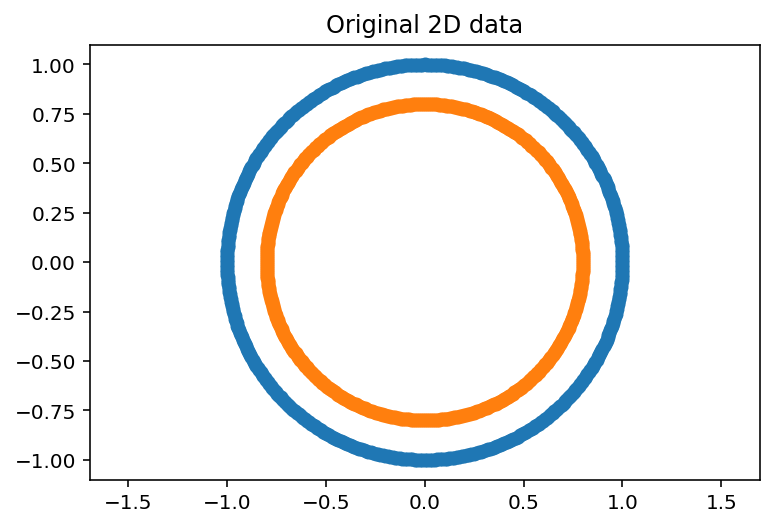

In [121]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split datat into train and test

In [122]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [123]:
nRounds = 3

In [124]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [125]:
dimProj = 10
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Make sequences

In [126]:
def makeSequences(dataset,Trounds=1):
    if Trounds==1:
        return np.expand_dims(dataset,1)
    elif Trounds>1:
        numSamps, numFeats = dataset.shape
        dataset_sequential = np.zeros((numSamps,Trounds,numFeats))
        for kk in range(Trounds):
            dataset_sequential[:,kk,:] = dataset
        return dataset_sequential

In [127]:
repsTrain = makeSequences(repsTrain_proj,nRounds)
print(repsTrain.shape)
repsTest = makeSequences(repsTest_proj,nRounds)
print(repsTest.shape)

(800, 3, 10)
(200, 3, 10)


#### Convert data to tensors

In [128]:
dataTrain = Variable(torch.from_numpy(repsTrain)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [129]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 128 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [130]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
else:
    print('GPU found, training on GPU')

No GPU, training on CPU


#### MLP AE

In [131]:
n_latent = 2

In [159]:
class RNNpredictor(nn.Module):
    def __init__(self, seq_len=3, n_features=10, hidden_dim = 2):
        super(RNNpredictor, self).__init__()
        
        ##Encoder
        self.layer1 = nn.RNN(input_size = n_features, hidden_size = hidden_dim, num_layers = 1, batch_first = True)
        self.layer2 = nn.RNN(input_size = hidden_dim, hidden_size = n_features, num_layers = 1, batch_first = True)
#         self.layer2 = nn.Linear(5,2)
#         self.layer3 = nn.Linear(2, 5)
#         self.layer4 = nn.Linear(5,10)
        
#         self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        #x = torch.unsqueeze(x,1)
        x1, hidden1 = self.layer1(x)
        #print(x1.shape)
        x2, hidden2 = self.layer2(x1)
        #print(x2.shape)
        
        return x2, hidden1

#create the NN
model = RNNpredictor()
print(model)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

RNNpredictor(
  (layer1): RNN(10, 2, batch_first=True)
  (layer2): RNN(2, 10, batch_first=True)
)


#### Count number of parameters

In [160]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

168

#### Trial pass

In [161]:
x.shape

torch.Size([1, 32, 10])

In [162]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        recon, latent = model(data)
    data, target = data.float(), target.float()
    x_out2, hidden_out2 = model(data)

    

#### Train AE with MSE

#### Specify loss function and optimizer

In [163]:
#specify loss function
criterion = nn.MSELoss()

#optimizer
eta = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

data.shape


torch.Size([32, 3, 10])

#### Addresses to collect activations and models

In [21]:
pp = 'Users\magicalkings\Final_project\tmp1\'
npp = 'tmp2\'
pp_npy = pp+npp+'npys/'
pp_pts = pp+npp+'pts/'

#### Train the network

In [164]:
#number of epochs
n_epochs = 50
div = n_epochs//25 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train model
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad() #clears older gradients
        output, _hidden = model(data) #forward pass
        loss = criterion(output[:,-1],data[:,-1].view(len(data),-1)) #calculate the loss for the batch
        loss.backward() #backprop
        optimizer.step() #update parameters in direction of the -ve gradient
        train_loss += loss.item()*data.size(0) #update training loss
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),'MLPAE.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), 'MLPAE_epoch_'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        model.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            data_test, target_test = data_test.float(), target_test.float()
            ## outputs
            output_test, act_hidden = model(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if i < len(data_test):
                    label = target_test.data[i]

                    activations_hidden_np[cnt] = act_hidden[i]

                    activations_out_np[cnt] = output_test[i,-1]

                    cnt += 1

        np.save('MLPAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save('MLPAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

  2%|▏         | 1/50 [00:00<00:08,  5.60it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.427856)


  4%|▍         | 2/50 [00:00<00:10,  4.48it/s]

Epoch: 2, Train Loss Decreased!! (0.427856-->0.407542)
Test Loss: 0.384830



  6%|▌         | 3/50 [00:00<00:09,  4.70it/s]

Epoch: 3, Train Loss Decreased!! (0.407542-->0.390605)


  8%|▊         | 4/50 [00:00<00:10,  4.28it/s]

Epoch: 4, Train Loss Decreased!! (0.390605-->0.376381)
Test Loss: 0.363298



 10%|█         | 5/50 [00:01<00:10,  4.39it/s]

Epoch: 5, Train Loss Decreased!! (0.376381-->0.363479)
Epoch: 6, Train Loss Decreased!! (0.363479-->0.351253)


 14%|█▍        | 7/50 [00:01<00:08,  4.87it/s]

Test Loss: 0.344018

Epoch: 7, Train Loss Decreased!! (0.351253-->0.338696)


 18%|█▊        | 9/50 [00:01<00:06,  6.13it/s]

Epoch: 8, Train Loss Decreased!! (0.338696-->0.325139)
Test Loss: 0.323346

Epoch: 9, Train Loss Decreased!! (0.325139-->0.310489)


 20%|██        | 10/50 [00:02<00:07,  5.58it/s]

Epoch: 10, Train Loss Decreased!! (0.310489-->0.294289)
Test Loss: 0.298747



 24%|██▍       | 12/50 [00:02<00:07,  5.32it/s]

Epoch: 11, Train Loss Decreased!! (0.294289-->0.276262)
Epoch: 12, Train Loss Decreased!! (0.276262-->0.257085)
Test Loss: 0.270346



 26%|██▌       | 13/50 [00:02<00:06,  5.77it/s]

Epoch: 13, Train Loss Decreased!! (0.257085-->0.236466)
Epoch: 14, Train Loss Decreased!! (0.236466-->0.215189)


 28%|██▊       | 14/50 [00:02<00:07,  5.10it/s]

Test Loss: 0.239977

Epoch: 15, Train Loss Decreased!! (0.215189-->0.193909)


 34%|███▍      | 17/50 [00:03<00:07,  4.49it/s]

Epoch: 16, Train Loss Decreased!! (0.193909-->0.173508)
Test Loss: 0.210732

Epoch: 17, Train Loss Decreased!! (0.173508-->0.154431)


 36%|███▌      | 18/50 [00:03<00:07,  4.07it/s]

Epoch: 18, Train Loss Decreased!! (0.154431-->0.136848)
Test Loss: 0.185071



 40%|████      | 20/50 [00:04<00:06,  4.74it/s]

Epoch: 19, Train Loss Decreased!! (0.136848-->0.121435)
Epoch: 20, Train Loss Decreased!! (0.121435-->0.108117)
Test Loss: 0.163831



 44%|████▍     | 22/50 [00:04<00:06,  4.30it/s]

Epoch: 21, Train Loss Decreased!! (0.108117-->0.097069)
Epoch: 22, Train Loss Decreased!! (0.097069-->0.087923)
Test Loss: 0.147683



 46%|████▌     | 23/50 [00:04<00:05,  4.87it/s]

Epoch: 23, Train Loss Decreased!! (0.087923-->0.080292)


 48%|████▊     | 24/50 [00:05<00:06,  3.79it/s]

Epoch: 24, Train Loss Decreased!! (0.080292-->0.074000)
Test Loss: 0.135596



 52%|█████▏    | 26/50 [00:05<00:05,  4.58it/s]

Epoch: 25, Train Loss Decreased!! (0.074000-->0.068705)
Epoch: 26, Train Loss Decreased!! (0.068705-->0.064128)
Test Loss: 0.126841



 54%|█████▍    | 27/50 [00:05<00:04,  5.09it/s]

Epoch: 27, Train Loss Decreased!! (0.064128-->0.060246)


 58%|█████▊    | 29/50 [00:06<00:04,  5.15it/s]

Epoch: 28, Train Loss Decreased!! (0.060246-->0.056696)
Test Loss: 0.120182

Epoch: 29, Train Loss Decreased!! (0.056696-->0.053551)


 60%|██████    | 30/50 [00:06<00:03,  5.25it/s]

Epoch: 30, Train Loss Decreased!! (0.053551-->0.050647)
Test Loss: 0.115235



 64%|██████▍   | 32/50 [00:06<00:03,  4.71it/s]

Epoch: 31, Train Loss Decreased!! (0.050647-->0.047978)
Epoch: 32, Train Loss Decreased!! (0.047978-->0.045492)
Test Loss: 0.111201



 68%|██████▊   | 34/50 [00:07<00:02,  5.48it/s]

Epoch: 33, Train Loss Decreased!! (0.045492-->0.043200)
Epoch: 34, Train Loss Decreased!! (0.043200-->0.041015)
Test Loss: 0.107811



 72%|███████▏  | 36/50 [00:07<00:02,  5.43it/s]

Epoch: 35, Train Loss Decreased!! (0.041015-->0.039019)
Epoch: 36, Train Loss Decreased!! (0.039019-->0.037119)
Test Loss: 0.104989



 76%|███████▌  | 38/50 [00:07<00:02,  5.74it/s]

Epoch: 37, Train Loss Decreased!! (0.037119-->0.035303)
Epoch: 38, Train Loss Decreased!! (0.035303-->0.033597)
Test Loss: 0.102695



 78%|███████▊  | 39/50 [00:08<00:01,  6.52it/s]

Epoch: 39, Train Loss Decreased!! (0.033597-->0.031948)


 80%|████████  | 40/50 [00:08<00:01,  5.11it/s]

Epoch: 40, Train Loss Decreased!! (0.031948-->0.030382)
Test Loss: 0.100642



 84%|████████▍ | 42/50 [00:08<00:01,  5.47it/s]

Epoch: 41, Train Loss Decreased!! (0.030382-->0.028903)
Epoch: 42, Train Loss Decreased!! (0.028903-->0.027498)
Test Loss: 0.098750



 86%|████████▌ | 43/50 [00:08<00:01,  5.87it/s]

Epoch: 43, Train Loss Decreased!! (0.027498-->0.026173)
Epoch: 44, Train Loss Decreased!! (0.026173-->0.024898)


 88%|████████▊ | 44/50 [00:09<00:01,  5.43it/s]

Test Loss: 0.097173

Epoch: 45, Train Loss Decreased!! (0.024898-->0.023702)


 94%|█████████▍| 47/50 [00:09<00:00,  6.24it/s]

Epoch: 46, Train Loss Decreased!! (0.023702-->0.022579)
Test Loss: 0.095826

Epoch: 47, Train Loss Decreased!! (0.022579-->0.021519)


 96%|█████████▌| 48/50 [00:09<00:00,  5.11it/s]

Epoch: 48, Train Loss Decreased!! (0.021519-->0.020528)
Test Loss: 0.094524



 98%|█████████▊| 49/50 [00:10<00:00,  4.74it/s]

Epoch: 49, Train Loss Decreased!! (0.020528-->0.019596)


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

Epoch: 50, Train Loss Decreased!! (0.019596-->0.018728)
Test Loss: 0.093416



Text(0, 0.5, 'MSE')

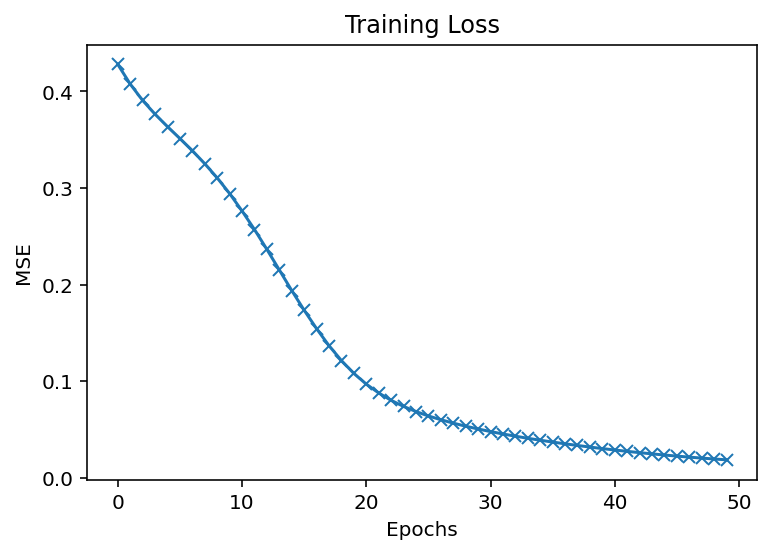

In [165]:
plt.plot((train_losses),'-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### Load best model

In [166]:
## best epoch = 50
print(best_epoch)

50


In [167]:
model.load_state_dict(torch.load('MLPAE.pt'))


<All keys matched successfully>

In [168]:
model.eval()

test_loss = 0.0
        
activations_latent_np = np.zeros((nTest,n_latent))
activations_out_np = np.zeros((nTest,dimProj))

cnt = 0

for data_test, target_test in test_loader:
    if train_on_gpu:
        data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
    data_test, target_test = data_test.float(), target_test.float()
    ## outputs
    output_test, act_hidden = model(data_test)

    # calculate the batch loss
    loss = criterion(output_test, data_test)

    # update test loss 
    test_loss += loss.item()*data_test.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_test = np.squeeze(output_test.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_test):
            label = target_test.data[i]

            activations_hidden_np[cnt] = act_hidden[i]

            activations_out_np[cnt] = output_test[i,-1]

            cnt += 1

np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.093416



In [169]:
model.eval()

train_loss = 0.0
        
activations_latent_train_np = np.zeros((nTrain,n_latent))
activations_out_train_np = np.zeros((nTrain,dimProj))

cnt = 0

for data_train, target_train in train_loader_noShuffle:
    if train_on_gpu:
        data_train, target_train = data_train.float().cuda(), target_train.float().cuda()
    data_train, target_train = data_train.float(), target_train.float()

    ## outputs
    output_train, act_hidden = model(data_train)

    # calculate the batch loss
    loss = criterion(output_train, data_train)

    # update train loss 
    train_loss += loss.item()*data_train.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_train = np.squeeze(output_train.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_train):
            label = target_train.data[i]

            activations_latent_train_np[cnt] = act_hidden[i]

            activations_out_train_np[cnt] = output_train[i,-1]

            cnt += 1

# np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
# np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average train loss
train_loss = train_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(train_loss))

Test Loss: 0.093381



#### Plot latent data

Text(0.5, 1.0, 'Latent Space - Test Data')

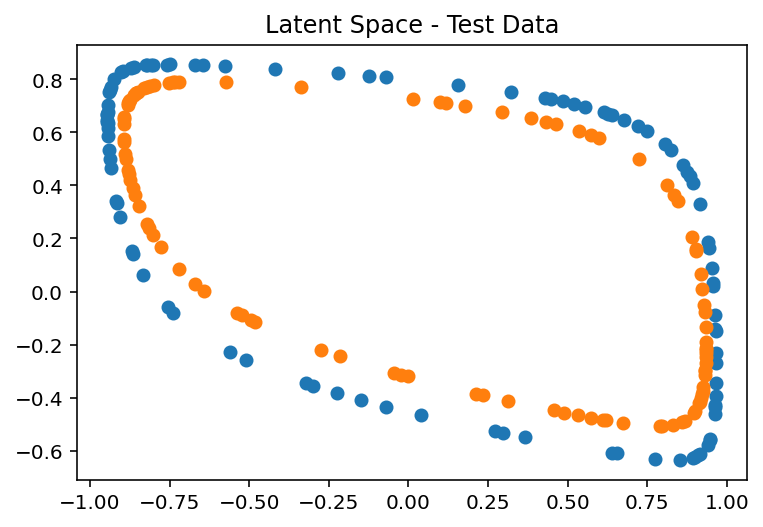

In [170]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTest==ii)[0]
    plt.scatter(activations_hidden_np[idx,0],activations_hidden_np[idx,1],c=col)
plt.title('Latent Space - Test Data')

In [178]:
activations_hidden_np.shape


(200, 2)

In [171]:
# for ii in range(2):
#     col = 'C' + str(ii)
#     idx = np.where(labelsTrain==ii)[0]
#     plt.scatter(activations_latent_train_np[idx,0],activations_latent_train_np[idx,1],c=col)
# plt.title('Train data')

#### Train a linear classifier on top of latent representations

In [172]:
from sklearn.linear_model import Perceptron

In [173]:
clf = Perceptron(tol=1e-3, random_state=22)
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))

Train Accuracy =  0.5025
Test Accuracy =  0.49


In [176]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = Perceptron(tol=1e-3, random_state=22)
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

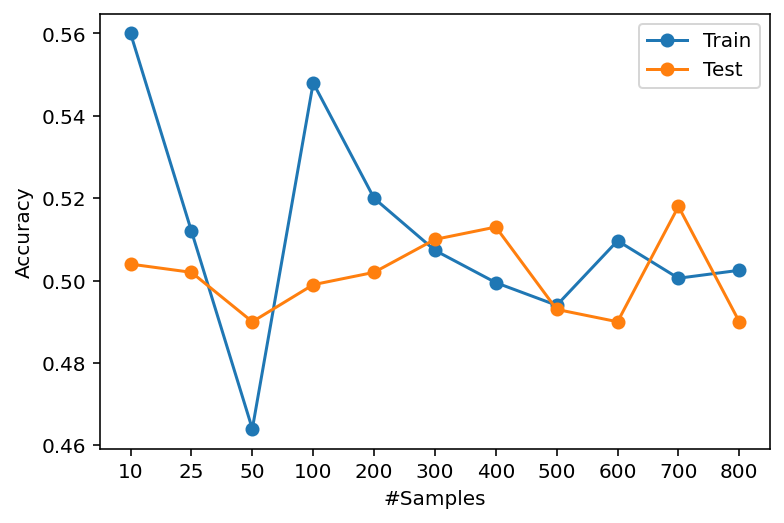

In [177]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()